#  CTC/Salary of New Hires

![](https://lh4.googleusercontent.com/u__xeeu1G_1FdLwOrlo8pLpeecf4RJ8gLO08d3B89B_4_wH-FpdBQAIasvfsjTY-wh4vaOzz3WV6GpOOgems0oabvee0VnOHwUf4vHmWceYvr6n5bI8kN-cYG-ombFBLLpGvNUFS)

#### Objective
The task is to help John from STA IT services to create a linear regression model in Python or R to predict the CTC/Salary of new hires from the data provided. Here is a snapshot of the case.

###### Steps
- Understand the data
- Transform categorical variables to the numerical variables
- Apply linear regression to predict the CTC
- Evaluate the results of the analysis

## Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xlrd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
import warnings

%matplotlib inline
plt.rcParams['figure.figsize'] = 12,8
sns.set_style('whitegrid')
warnings.filterwarnings(action='ignore')

In [4]:
print(f'Numpy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')
print(f'Sklearn version: {sklearn.__version__}')
print(f'Seaborn version: {sns.__version__}')
print(f'Matplotlib version: {mlt.__version__}')


Numpy version: 1.21.6
Pandas version: 1.3.5
Sklearn version: 1.0.2
Seaborn version: 0.11.2
Matplotlib version: 3.2.2


## Loading Dataset

In [5]:
def read_google_docs_path(url, sheet_name=0):
    sheet_id = url.split('/')[5]
    path = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
    return path

In [6]:
# reading googledocs for the training dataset
url = 'https://docs.google.com/spreadsheets/d/1bcOXd9dFhgxsmonqC0TtFLQrAKfzxQNL/edit#gid=725400095'
path = read_google_docs_path(url, 'Data')
df = pd.read_csv(path,usecols=[1,2,3,4,5,6,7,8])
df.head()

,College,Role,City type,Previous CTC,Previous job changes,Graduation marks,Exp (Months),CTC
0,Tier 1,Manager,Non-Metro,"55,523.00",3,66,19,"71,406.58"
1,Tier 2,Executive,Metro,"57,081.00",1,84,18,"68,005.87"
2,Tier 2,Executive,Metro,"60,347.00",2,52,28,"76,764.02"
3,Tier 3,Executive,Metro,"49,010.00",2,81,33,"82,092.39"
4,Tier 3,Executive,Metro,"57,879.00",4,74,32,"73,878.10"


In [7]:
# reading googledocs for the testing dataset
url = 'https://docs.google.com/spreadsheets/d/1rsyHvyjVzl8YoIzRgyqNTxJIVUoNhivL/edit#gid=500287326'
path = read_google_docs_path(url)
test_dataset = pd.read_csv(path, usecols=[0,1,2,3,4,5,6,7,8,9,10,11])
test_dataset.head()

,College,Role,City type,College_T1,College_T2,Role_Manager,City_Metro,previous CTC,previous job changes,Graduation marks,Exp,Actual CTC
0,Tier 1,Manager,Non-Metro,1,0,1,0,55523,3,66,19,71406.57653
1,Tier 2,Executive,Metro,0,1,0,1,57081,1,84,18,68005.87063
2,Tier 2,Executive,Metro,0,1,0,1,60347,2,52,28,76764.02028
3,Tier 3,Executive,Metro,0,0,0,1,49010,2,81,33,82092.38688
4,Tier 3,Executive,Metro,0,0,0,1,57879,4,74,32,73878.09773


In [8]:
print('Training Dataset',df.shape)
print('Testing Dataset',test_dataset.shape)

Training Dataset (1338, 8)
Testing Dataset (1338, 12)


In [9]:
# Removed the target value of the test dataset
test_target = test_dataset['Actual CTC'].values
test_dataset.drop('Actual CTC',axis=1,inplace=True)

Looking at the two dataset, we can see that the data is inconsistence, the number of columns doesn't match in the two dataset. Lets take a look further

In [10]:
print('Training Dataset',df.shape)
print('Testing Dataset',test_dataset.shape)

Training Dataset (1338, 8)
Testing Dataset (1338, 11)


The training dataset has 8 columns including the target value,
While the testing dataset has 11 columns excluding the target value

## Data Overview

In [11]:
print('Training Dataset:', df.info(),'\n\n')
print('Testing Dataset:', test_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   College               1338 non-null   object
 1   Role                  1338 non-null   object
 2   City type             1338 non-null   object
 3   Previous CTC          1338 non-null   object
 4   Previous job changes  1338 non-null   int64 
 5   Graduation marks      1338 non-null   int64 
 6   Exp (Months)          1338 non-null   int64 
 7   CTC                   1338 non-null   object
dtypes: int64(3), object(5)
memory usage: 83.8+ KB
Training Dataset: None 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   College               1338 non-null   object
 1   Role                  1338 non-null   object
 2   City 

Some of the columns names doesn't match in the two dataset and there are some one hot encoding in the test_dataset

In [12]:
df.describe()

,Previous job changes,Graduation marks,Exp (Months)
count,1338.000000,1338.000000,1338.000000
mean,2.525411,59.890882,39.207025
std,1.123502,14.894696,14.049960
min,1.000000,35.000000,18.000000
25%,2.000000,47.000000,27.000000
50%,3.000000,60.000000,39.000000
75%,4.000000,73.000000,51.000000
max,4.000000,85.000000,64.000000


In [13]:
test_dataset.describe()

,College_T1,College_T2,Role_Manager,City_Metro,previous CTC,previous job changes,Graduation marks,Exp
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,0.485052,0.272048,0.204783,0.505232,55581.762332,2.525411,59.890882,39.207025
std,0.499963,0.445181,0.403694,0.500160,6685.600553,1.123502,14.894696,14.049960
min,0.000000,0.000000,0.000000,0.000000,36990.000000,1.000000,35.000000,18.000000
25%,0.000000,0.000000,0.000000,0.000000,50547.000000,2.000000,47.000000,27.000000
50%,0.000000,0.000000,0.000000,1.000000,55293.500000,3.000000,60.000000,39.000000
75%,1.000000,1.000000,0.000000,1.000000,60150.500000,4.000000,73.000000,51.000000
max,1.000000,1.000000,1.000000,1.000000,77911.000000,4.000000,85.000000,64.000000


## Data Cleaning

Notice that the previous CTC and CTC in training dataset is of an object datatype, so we need to change it to float, but first we need to remove the comma's in the number, else we won't be able to convert it.

In [14]:
# we use string replace function to remove the ',', the convert the dtype into float type
df['CTC'] = df['CTC'].apply(lambda x: x.replace(',','')).astype(np.float64)
df['Previous CTC'] = df['Previous CTC'].apply(lambda x: x.replace(',','')).astype(np.float64)

In [15]:
df.head()

,College,Role,City type,Previous CTC,Previous job changes,Graduation marks,Exp (Months),CTC
0,Tier 1,Manager,Non-Metro,55523.0,3,66,19,71406.58
1,Tier 2,Executive,Metro,57081.0,1,84,18,68005.87
2,Tier 2,Executive,Metro,60347.0,2,52,28,76764.02
3,Tier 3,Executive,Metro,49010.0,2,81,33,82092.39
4,Tier 3,Executive,Metro,57879.0,4,74,32,73878.10


In [16]:
df.describe()

,Previous CTC,Previous job changes,Graduation marks,Exp (Months),CTC
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,55581.762332,2.525411,59.890882,39.207025,75459.339036
std,6685.600553,1.123502,14.894696,14.049960,12551.280147
min,36990.000000,1.000000,35.000000,18.000000,53020.320000
25%,50547.000000,2.000000,47.000000,27.000000,66905.067500
50%,55293.500000,3.000000,60.000000,39.000000,73112.640000
75%,60150.500000,4.000000,73.000000,51.000000,80747.175000
max,77911.000000,4.000000,85.000000,64.000000,123416.990000


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   College               1338 non-null   object 
 1   Role                  1338 non-null   object 
 2   City type             1338 non-null   object 
 3   Previous CTC          1338 non-null   float64
 4   Previous job changes  1338 non-null   int64  
 5   Graduation marks      1338 non-null   int64  
 6   Exp (Months)          1338 non-null   int64  
 7   CTC                   1338 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 83.8+ KB


In [18]:
test_columns = test_dataset.columns

In [19]:
# change the columns to lower case and replace spaces between words with '_' underscore
columns = [col.lower().replace(' ','_').replace('(','').replace(')','') for col in df.columns]
columns

['college',
 'role',
 'city_type',
 'previous_ctc',
 'previous_job_changes',
 'graduation_marks',
 'exp_months',
 'ctc']

In [20]:
# change our columns in the dataframe
df.columns = columns

In [21]:
# Checking for missing value
df.isnull().sum()

college                 0
role                    0
city_type               0
previous_ctc            0
previous_job_changes    0
graduation_marks        0
exp_months              0
ctc                     0
dtype: int64

In [22]:
# Checking for missing value in the test data
test_dataset.isnull().sum()

College                 0
Role                    0
City type               0
College_T1              0
College_T2              0
Role_Manager            0
City_Metro              0
previous CTC            0
previous job changes    0
Graduation marks        0
Exp                     0
dtype: int64

We don't have missing value in both training and test data

## Exploratory Data Analysis

Checking for the Unique values of our object datatype

In [23]:
for col in df.columns:
    if df[col].dtype in ['object']:
        print(f'{col} unique values: {df[col].unique()}','\n')

college unique values: ['Tier 1' 'Tier 2' 'Tier 3'] 

role unique values: ['Manager' 'Executive'] 

city_type unique values: ['Non-Metro' 'Metro'] 



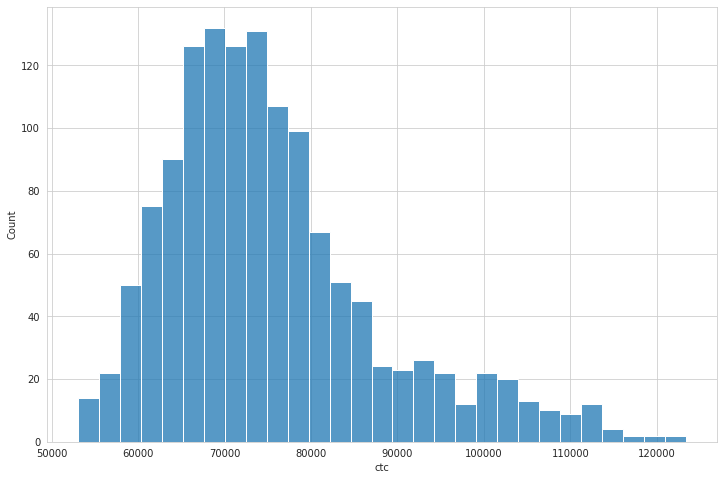

In [24]:
sns.histplot(df['ctc'])

Our target value is almost symmetrical but have some outliers to the right.
Our mean will be greater than median

In [25]:
cat_cols = [col for col in df.select_dtypes(include='object')]
cat_cols

['college', 'role', 'city_type']

In [26]:
num_cols = [col for col in df.select_dtypes(exclude='object')]
num_cols

['previous_ctc',
 'previous_job_changes',
 'graduation_marks',
 'exp_months',
 'ctc']

In [27]:
# Value counts of different categorical columns
for col in cat_cols:
    print(df[col].value_counts(), '\n')

Tier 1    649
Tier 2    364
Tier 3    325
Name: college, dtype: int64 

Executive    1064
Manager       274
Name: role, dtype: int64 

Metro        676
Non-Metro    662
Name: city_type, dtype: int64 



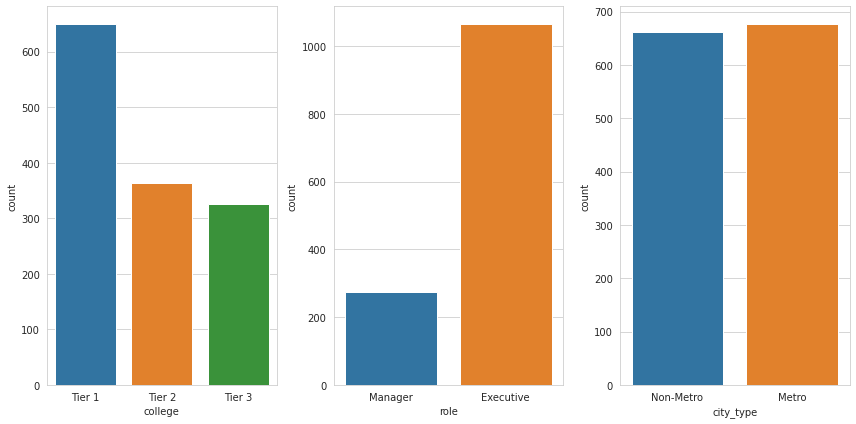

In [28]:
fig, ax = plt.subplots(ncols=3,nrows=1, figsize=(12,6))
for idx,ax in enumerate(ax.flatten()):
    sns.countplot(x=cat_cols[idx], data=df, ax=ax)
plt.tight_layout()

- Count of Tier1 is almost as twice as the count of Tier3
- Tier2 count is greater than Tier3 by a little margin. 
- Manager is 1/4 of Executives

In [29]:
df['previous_job_changes'].value_counts()

3    348
4    344
1    333
2    313
Name: previous_job_changes, dtype: int64

The difference in value counts of previous_job_changes is +_35 

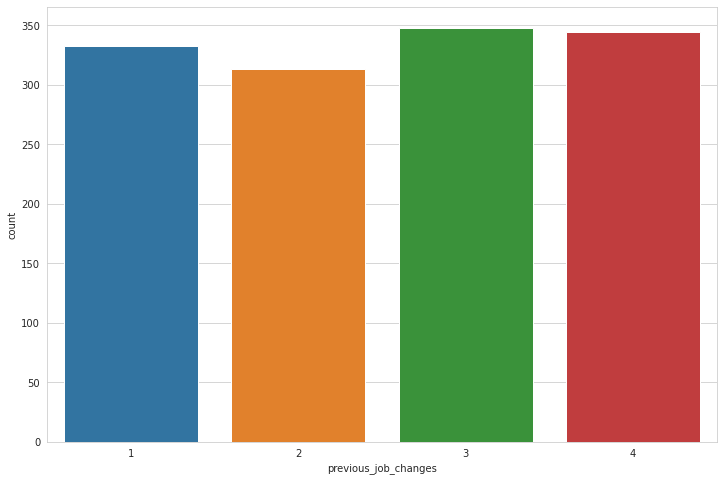

In [30]:
sns.countplot(df['previous_job_changes'])

Though Previous_job_changes is of Int datatype, but it is a categorical varible

In [31]:
cat_cols.append('previous_job_changes')
num_cols.remove('previous_job_changes')

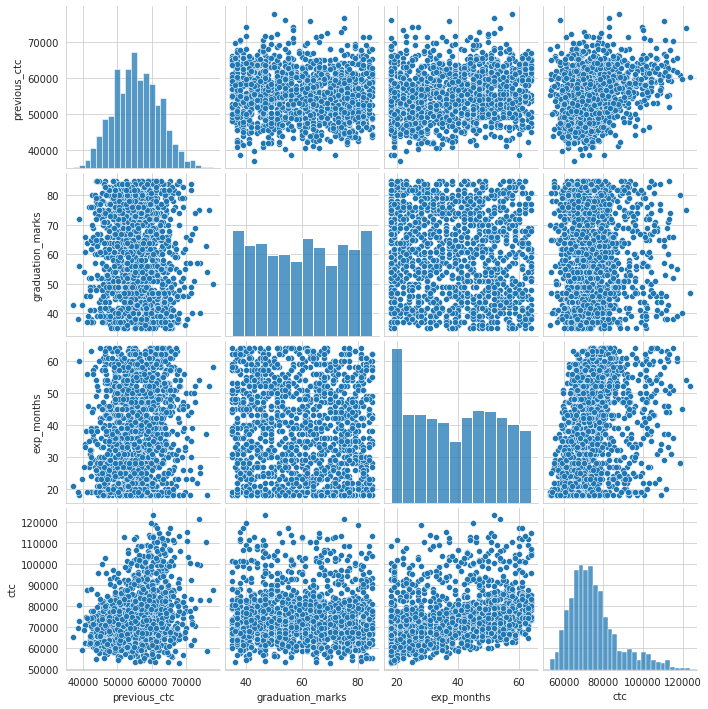

In [32]:
sns.pairplot(data=df, vars=num_cols)

The Previous_CTC has a Bell shape Curve so it has no outlier.
Except  the previous_ctc and ctc having a weak correlation, there seems to be no other correlation between the other variables.

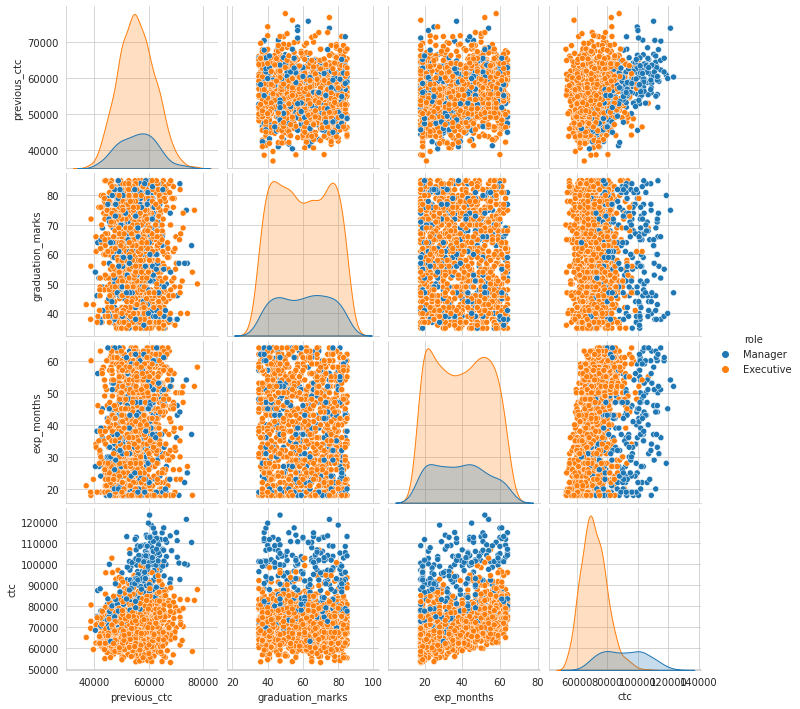

In [33]:
sns.pairplot(data=df, vars=num_cols, hue='role')

- Both CTC and Previous CTC are Symmetrical in shape, The managers ctc range is very wide compared to the executive.
- Both CTC and Previous CTC have a small degree of correlation

Looking at pairplot with regards to role column
- In the CTC, Executive salary are lower than managers
- Graduations marks, even though marks are the same, but the CTC is still  higher for Managers than Executives.
- same as exp_months as well

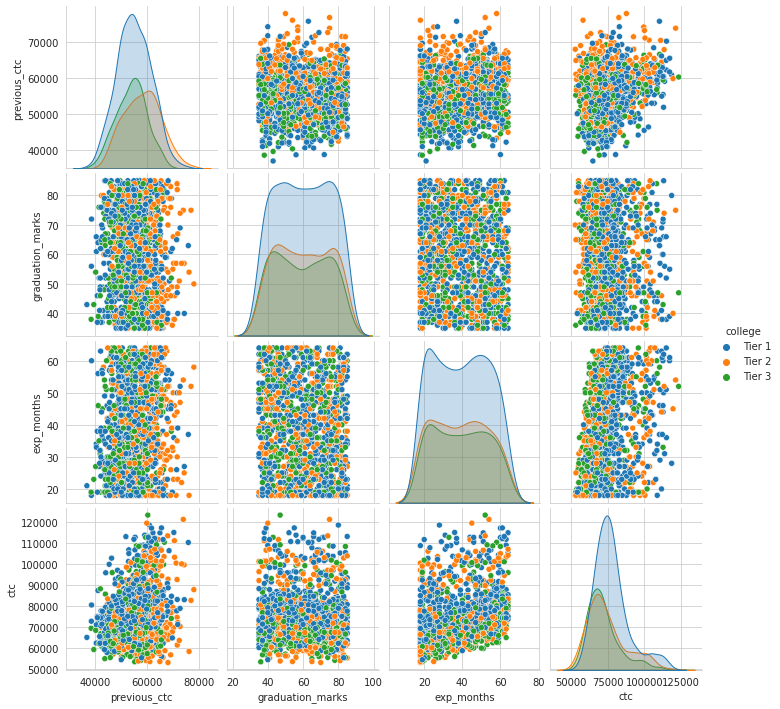

In [34]:
sns.pairplot(data=df, vars=num_cols, hue='college')

- From the above it can be that Tier 2 was having the highest previous_ctc in both grad_mark, exp_months, ctc scatterplot.
- Their are more Tier 2 recieving higher previous_ctc than Tier 1.
- Tier 3 has the highest ctc, but their are more Tier 1 recieving high ctc than the rest of the Tiers.

In [35]:
df.groupby('role')[['previous_ctc','ctc']].mean()

,previous_ctc,ctc
role,,
Executive,55509.836466,71477.237585
Manager,55861.065693,90922.681898


- The difference between Executive and Manager in the current ctc is 20000+
- While there are only approx 300 difference in previous_ctc 

In [36]:
df.groupby('college')[['previous_ctc','ctc']].mean()

,previous_ctc,ctc
college,,
Tier 1,54961.727273,77595.583282
Tier 2,58119.538462,74601.172995
Tier 3,53977.615385,72154.569569


- Tier 2 has the highest previous_ctc while Tier1 has the highest current ctc.


In [37]:
df.groupby(['role','college']).count()

city_type  previous_ctc  previous_job_changes  \
role      college                                                  
Executive Tier 1         524           524                   524   
          Tier 2         273           273                   273   
          Tier 3         267           267                   267   
Manager   Tier 1         125           125                   125   
          Tier 2          91            91                    91   
          Tier 3          58            58                    58   

                   graduation_marks  exp_months  ctc  
role      college                                     
Executive Tier 1                524         524  524  
          Tier 2                273         273  273  
          Tier 3                267         267  267  
Manager   Tier 1                125         125  125  
          Tier 2                 91          91   91  
          Tier 3                 58          58   58

In [38]:
df.groupby(['role','college'])[['previous_ctc','ctc']].mean()

previous_ctc           ctc
role      college                            
Executive Tier 1   54920.694656  74070.392576
          Tier 2   58144.630037  68980.571978
          Tier 3   53972.052434  68940.819963
Manager   Tier 1   55133.736000  92373.182720
          Tier 2   58044.263736  91462.976044
          Tier 3   54003.224138  86948.899655

Both the Executive and Manager Tier 2 had the highest mean for the previous_ctc, Tier 1 has the highest mean in ctc

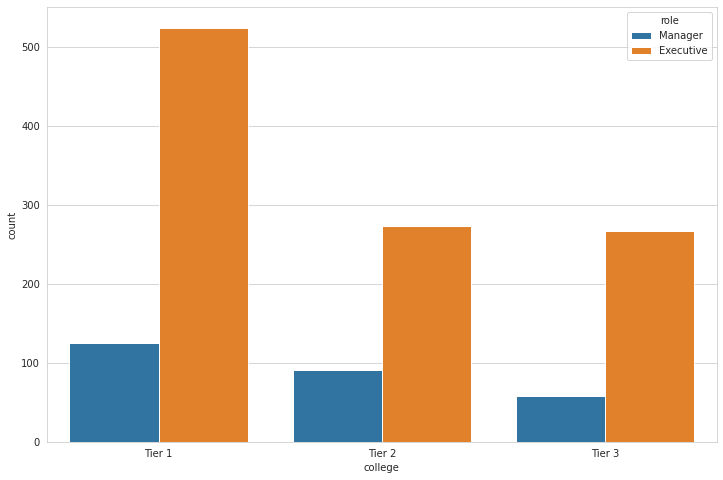

In [39]:
sns.countplot(x='college',hue='role', data=df)

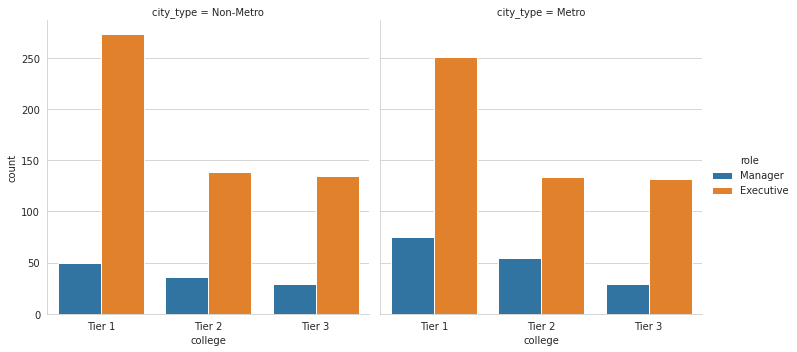

In [40]:
g = sns.catplot(x="college", 
                hue="role",
                col='city_type',
                kind='count',
                data=df)

Though we have morw managers and executives in the Tier 1 than Tier 2, but how is the mean of Tier 2 is higher than Tier 1.

In [41]:
df.groupby(['role','city_type', 'college', 'previous_job_changes'])[['previous_ctc','ctc']].mean()

previous_ctc           ctc
role      city_type college previous_job_changes                            
Executive Metro     Tier 1  1                     55116.442623  75310.585410
                            2                     53514.729167  73846.690000
                            3                     55799.500000  77764.398974
                            4                     54578.109375  75938.631719
                    Tier 2  1                     58861.481481  69538.455556
                            2                     58910.439024  70979.871707
                            3                     59429.060606  71675.523939
                            4                     58876.636364  70317.160909
                    Tier 3  1                     52358.805556  72476.598611
                            2                     54480.942857  71536.816286
                            3                     53505.205882  69478.091765
                            4                     53304.888889  70383.244815
          Non-Metro Tier 1  1                     55731.000000  72169.030847
                            2                     54541.375000  71252.627083
                            3                     55259.735294  72514.003824
                            4                     54452.756757  73371.474324
                    Tier 2  1                     58102.300000  66691.421250
                            2                     55619.769231  66619.543462
                            3                     57398.088235  69090.076176
                            4                     57514.538462  66907.613846
                    Tier 3  1                     53822.666667  68181.939167
                            2                     54416.413793  67701.066897
                            3                     53424.771429  65448.017714
                            4                     56423.428571  66373.963143
Manager   Metro     Tier 1  1                     56965.764706  95279.890000
                            2                     57125.666667  98172.041333
                            3                     54361.727273  92742.506818
                            4                     56511.523810  93499.591905
                    Tier 2  1                     59894.000000  95204.239091
                            2                     57202.437500  93642.833750
                            3                     57877.916667  90639.910000
                            4                     58493.375000  96096.941875
                    Tier 3  1                     55691.166667  92046.879167
                            2                     53448.600000  82288.608000
                            3                     55118.142857  92353.172857
                            4                     53923.600000  88187.064000
          Non-Metro Tier 1  1                     53504.866667  87899.000667
                            2                     53802.076923  90216.480769
                            3                     51526.777778  85846.100000
                            4                     55228.692308  91274.488462
                    Tier 2  1                     56336.300000  86802.390000
                            2                     60224.600000  88107.416000
                            3                     54535.916667  82282.460833
                            4                     62067.666667  95157.594444
                    Tier 3  1                     55822.222222  86953.512222
                            2                     54093.375000  83907.555000
                            3                     48498.000000  83607.597500
                            4                     51508.250000  81418.827500

In [42]:
df.groupby(['role', 'previous_job_changes'])[['ctc']].count()

ctc
role      previous_job_changes     
Executive 1                     259
          2                     251
          3                     282
          4                     272
Manager   1                      74
          2                      62
          3                      66
          4                      72

- Executives are more likely to change jobs, they are 2/3 more likely to change job than a manager.
This might be biased, because the manager is just 1/4 of the Executives.

In [43]:
df.groupby(['role', 'previous_job_changes'])[['ctc']].mean()

ctc
role      previous_job_changes              
Executive 1                     71277.301313
          2                     70853.516534
          3                     72212.290780
          4                     71481.106985
Manager   1                     91089.970676
          2                     91401.947903
          3                     88923.046970
          4                     92171.043611

- But changing of jobs won't necessaryly increase or decrease your pay

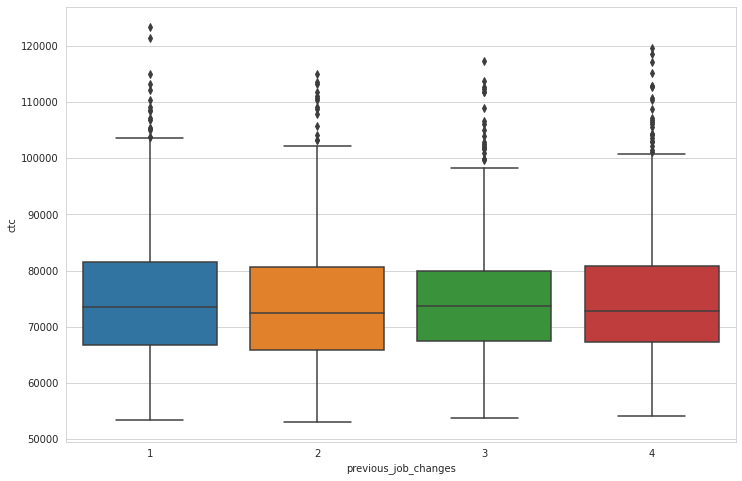

In [44]:
sns.boxplot(x='previous_job_changes', y='ctc', data=df)

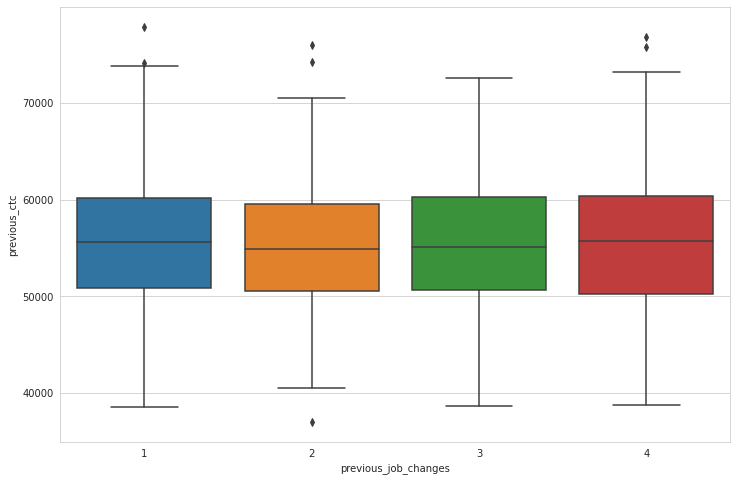

In [45]:
sns.boxplot(x='previous_job_changes', y='previous_ctc', data=df)

From the above chart we can deduce that their average and iqr only have a slight difference, so won't have much effect on your salary. But then lets check for both roles, college, city

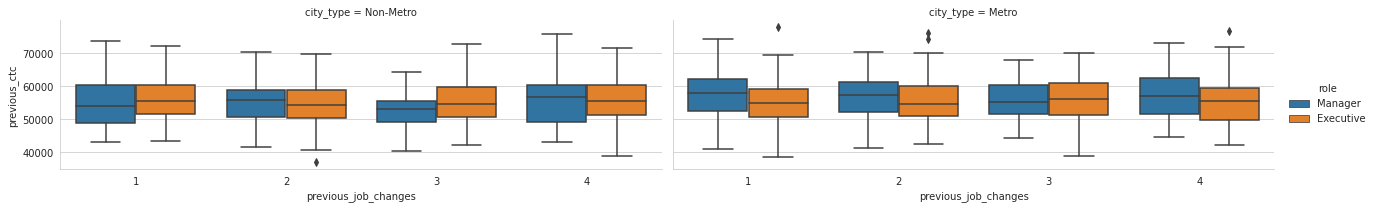

In [46]:
g = sns.catplot(x="previous_job_changes",
                y='previous_ctc', 
                hue="role",
                col='city_type',
                kind='box',
                height=3, aspect=3,
                data=df)

There is no significant difference, that shows that number of job changes have great influence on the previous_ctc for both manager and executive

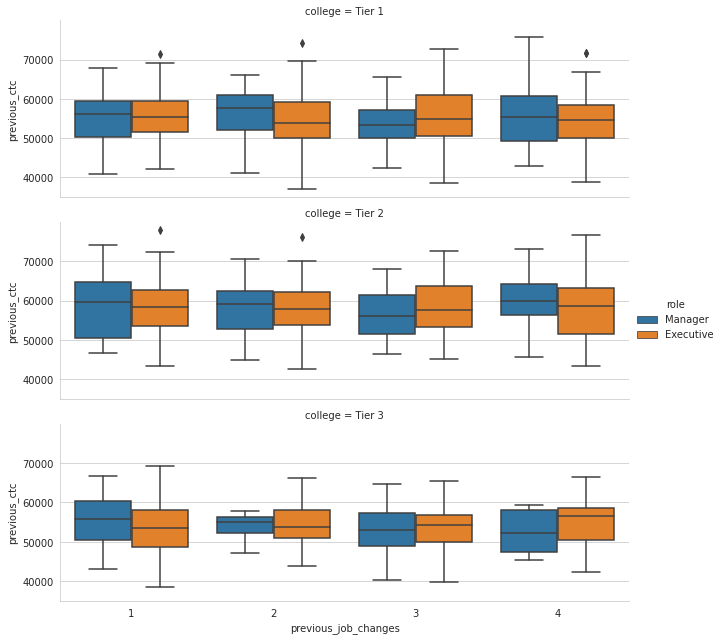

In [47]:
g = sns.catplot(x="previous_job_changes",
                y='previous_ctc', 
                hue="role",
                row='college',
                kind='box',
                height=3, aspect=3,
                data=df)

- Tier2 average for both Manager and Executivee where relatively higher than the rest of the tiers

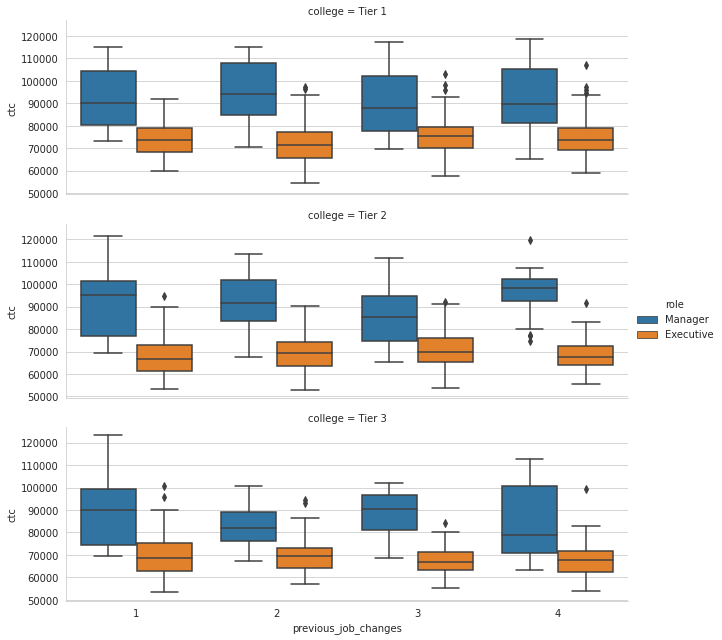

In [48]:
g = sns.catplot(x="previous_job_changes",
                y='ctc', 
                hue="role",
                row='college',
                kind='box',
                height=3, aspect=3,
                data=df)

Tier 2 is having the highest average at previous_job_changes=4

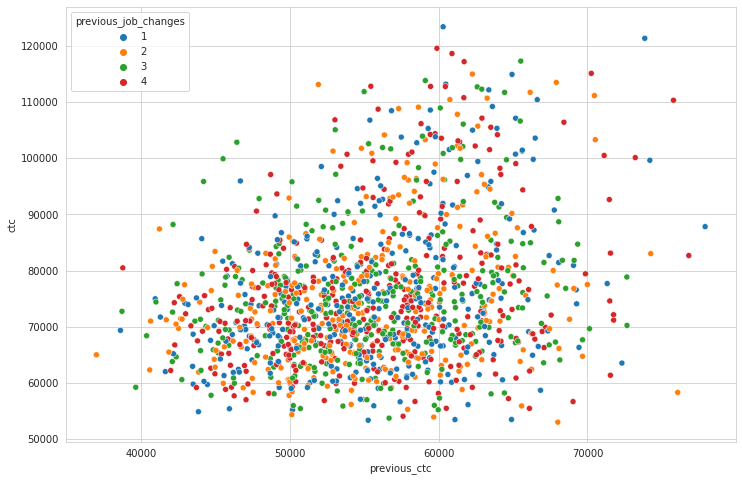

In [49]:
sns.scatterplot(x='previous_ctc', y='ctc',hue='previous_job_changes',data=df, palette="tab10")

## Feature Engineering

In [50]:
df.head()

,college,role,city_type,previous_ctc,previous_job_changes,graduation_marks,exp_months,ctc
0,Tier 1,Manager,Non-Metro,55523.0,3,66,19,71406.58
1,Tier 2,Executive,Metro,57081.0,1,84,18,68005.87
2,Tier 2,Executive,Metro,60347.0,2,52,28,76764.02
3,Tier 3,Executive,Metro,49010.0,2,81,33,82092.39
4,Tier 3,Executive,Metro,57879.0,4,74,32,73878.10


In [51]:
def exp_level(x):
    if x < 24:
        return 'junior'
    elif x >= 24 and x < 48:
        return 'intermediate'
    else:
        return 'senior' 
df['exp_level'] = df['exp_months'].apply(exp_level)

In [52]:
def create_features(df):
    df['grad_mark_to_prev_ctc'] = df['graduation_marks']/df['previous_ctc']
    df['exp_to_job_change'] = df['exp_months']/df['previous_job_changes']
    df['prev_ctc_to_exp'] = df['previous_ctc']/df['exp_months']
    df['base_price'] = df['previous_ctc']/(df['previous_job_changes'] * df['exp_months'])
    return df

In [53]:
create_features(df).head()

,college,role,city_type,previous_ctc,previous_job_changes,graduation_marks,exp_months,ctc,exp_level,grad_mark_to_prev_ctc,exp_to_job_change,prev_ctc_to_exp,base_price
0,Tier 1,Manager,Non-Metro,55523.0,3,66,19,71406.58,junior,0.001189,6.333333,2922.263158,974.087719
1,Tier 2,Executive,Metro,57081.0,1,84,18,68005.87,junior,0.001472,18.000000,3171.166667,3171.166667
2,Tier 2,Executive,Metro,60347.0,2,52,28,76764.02,intermediate,0.000862,14.000000,2155.250000,1077.625000
3,Tier 3,Executive,Metro,49010.0,2,81,33,82092.39,intermediate,0.001653,16.500000,1485.151515,742.575758
4,Tier 3,Executive,Metro,57879.0,4,74,32,73878.10,intermediate,0.001279,8.000000,1808.718750,452.179688


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   college                1338 non-null   object 
 1   role                   1338 non-null   object 
 2   city_type              1338 non-null   object 
 3   previous_ctc           1338 non-null   float64
 4   previous_job_changes   1338 non-null   int64  
 5   graduation_marks       1338 non-null   int64  
 6   exp_months             1338 non-null   int64  
 7   ctc                    1338 non-null   float64
 8   exp_level              1338 non-null   object 
 9   grad_mark_to_prev_ctc  1338 non-null   float64
 10  exp_to_job_change      1338 non-null   float64
 11  prev_ctc_to_exp        1338 non-null   float64
 12  base_price             1338 non-null   float64
dtypes: float64(6), int64(3), object(4)
memory usage: 136.0+ KB


In [55]:
# update cat_cols and num_cols
cat_cols += ['exp_level']

In [56]:
num_cols = [col for col in df.columns if col not in cat_cols ]
num_cols

['previous_ctc',
 'graduation_marks',
 'exp_months',
 'ctc',
 'grad_mark_to_prev_ctc',
 'exp_to_job_change',
 'prev_ctc_to_exp',
 'base_price']

In [57]:
cat_cols

['college', 'role', 'city_type', 'previous_job_changes', 'exp_level']

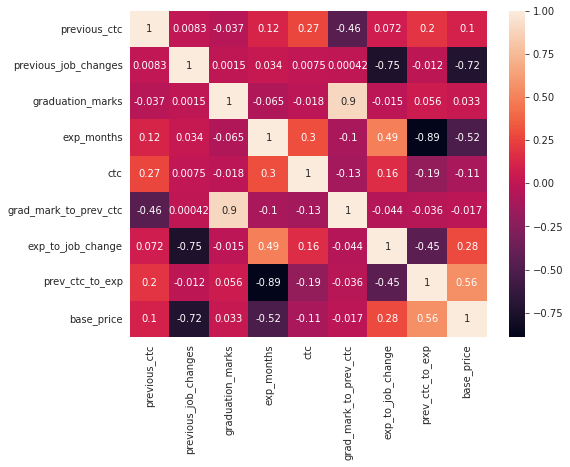

In [58]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True)

graduation_marks is highly correlated with grad_mark_to_prev_ctc

In [59]:
num_cols.remove('graduation_marks')

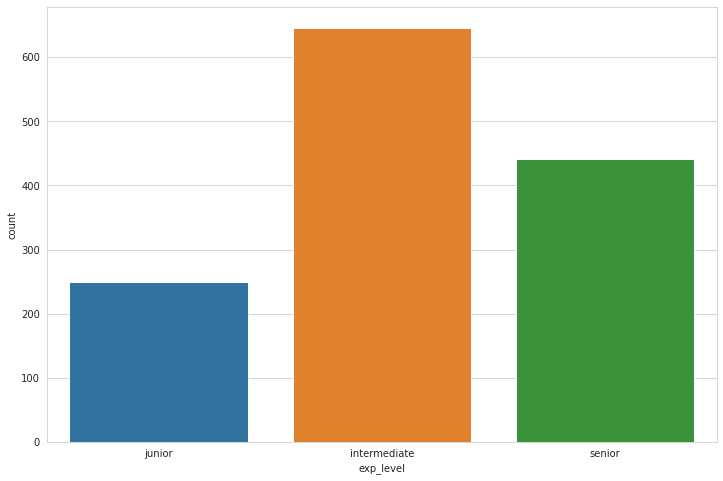

In [60]:
sns.countplot(df['exp_level'])

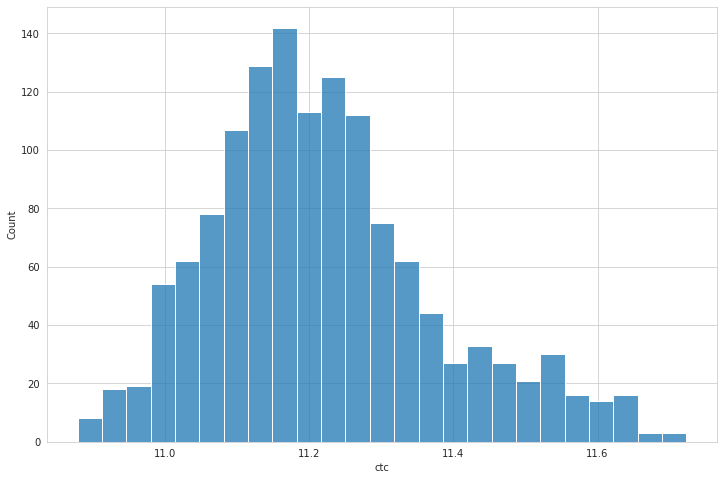

In [61]:
sns.histplot(np.log(df['ctc']))

In [62]:
np.log(df['ctc'])

0       11.176145
1       11.127349
2       11.248491
3       11.315601
4       11.210172
          ...    
1333    11.152133
1334    11.146182
1335    11.103419
1336    11.067332
1337    11.330757
Name: ctc, Length: 1338, dtype: float64

In [63]:
np.exp(np.log(df['ctc']).values)

array([71406.58, 68005.87, 76764.02, ..., 66397.77, 64044.38, 83346.06])

## Model Building

#### Data Preprocessing

In [64]:
X = df.drop('ctc',axis=1)
# y = df['ctc'].values
y = np.log(df['ctc']).values

In [256]:
X.head()

,college,role,city_type,previous_ctc,previous_job_changes,graduation_marks,exp_months,exp_level,grad_mark_to_prev_ctc,exp_to_job_change,prev_ctc_to_exp,base_price
0,Tier 1,Manager,Non-Metro,55523.0,3,66,19,junior,0.001189,6.333333,2922.263158,974.087719
1,Tier 2,Executive,Metro,57081.0,1,84,18,junior,0.001472,18.000000,3171.166667,3171.166667
2,Tier 2,Executive,Metro,60347.0,2,52,28,intermediate,0.000862,14.000000,2155.250000,1077.625000
3,Tier 3,Executive,Metro,49010.0,2,81,33,intermediate,0.001653,16.500000,1485.151515,742.575758
4,Tier 3,Executive,Metro,57879.0,4,74,32,intermediate,0.001279,8.000000,1808.718750,452.179688


In [65]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.25, random_state=1)

In [66]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1003, 12), (335, 12), (1003,), (335,))

In [67]:
oh_encode = OneHotEncoder(handle_unknown='ignore',sparse=False)

In [68]:
oh_train = oh_encode.fit_transform(X_train[cat_cols])
oh_val = oh_encode.transform(X_val[cat_cols])

In [69]:
oh_train_df = pd.DataFrame(oh_train, columns=oh_encode.get_feature_names_out())
oh_val_df = pd.DataFrame(oh_val, columns=oh_encode.get_feature_names_out())
oh_train_df.index = X_train.index
oh_val_df.index = X_val.index

In [70]:
num_cols.remove('ctc')

In [71]:
num_X_train = X_train[num_cols]
num_X_val = X_val[num_cols]
oh_train_df = pd.concat([num_X_train, oh_train_df],axis=1)
oh_val_df = pd.concat([num_X_val, oh_val_df],axis=1)

In [72]:
oh_train_df.head()

,previous_ctc,exp_months,grad_mark_to_prev_ctc,exp_to_job_change,prev_ctc_to_exp,base_price,college_Tier 1,college_Tier 2,college_Tier 3,role_Executive,role_Manager,city_type_Metro,city_type_Non-Metro,previous_job_changes_1,previous_job_changes_2,previous_job_changes_3,previous_job_changes_4,exp_level_intermediate,exp_level_junior,exp_level_senior
1043,46857.0,28,0.000832,14.000000,1673.464286,836.732143,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
968,54340.0,21,0.000975,10.500000,2587.619048,1293.809524,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
594,68145.0,41,0.001233,13.666667,1662.073171,554.024390,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1079,54644.0,63,0.000732,31.500000,867.365079,433.682540,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1051,55202.0,64,0.001014,64.000000,862.531250,862.531250,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [73]:
scaler = MinMaxScaler()
X_train_scaler = scaler.fit_transform(oh_train_df)
X_val_scaler = scaler.transform(oh_val_df)

In [74]:
scaler.get_feature_names_out()

array(['previous_ctc', 'exp_months', 'grad_mark_to_prev_ctc',
       'exp_to_job_change', 'prev_ctc_to_exp', 'base_price',
       'college_Tier 1', 'college_Tier 2', 'college_Tier 3',
       'role_Executive', 'role_Manager', 'city_type_Metro',
       'city_type_Non-Metro', 'previous_job_changes_1',
       'previous_job_changes_2', 'previous_job_changes_3',
       'previous_job_changes_4', 'exp_level_intermediate',
       'exp_level_junior', 'exp_level_senior'], dtype=object)

##### Baseline

In [82]:
preds = np.zeros(test_target.shape[0])
preds += df['ctc'].mean()

In [83]:
sample_sub = test_dataset['previous CTC']
sample_sub = sample_sub.apply(lambda x: 68000).reset_index().rename(columns = {'previous CTC':'predictions'})
sample_sub.head()

,index,predictions
0,0,68000
1,1,68000
2,2,68000
3,3,68000
4,4,68000


In [84]:
np.sum((test_target - preds)**2)/preds.shape[0]

157416897.33561996

### Improvement on Baseline Model

In [85]:
linreg = LinearRegression()

In [86]:
linreg.fit(X_train_scaler, y_train)

LinearRegression()

In [87]:
preds = linreg.predict(X_val_scaler)

In [88]:
mean_squared_error(np.exp(y_val), np.exp(preds))

62890267.047086105

In [229]:
def fit_predict(model, X_train, x_test, train=True):
    if train:
        model.fit(X_train, y_train)
        preds = model.predict(x_test)
        print(mean_squared_error(np.exp(y_val), np.exp(preds)))
    else:
        preds = model.predict(x_test)
    return preds

In [99]:
preds = fit_predict(linreg,X_train_scaler, X_val_scaler)

62890267.047086105


##### models

In [92]:
sgdreg = SGDRegressor()
dt = DecisionTreeRegressor(random_state=1)
bag = BaggingRegressor(base_estimator=DecisionTreeRegressor(), random_state=1)
gbm = GradientBoostingRegressor(random_state=1)
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), loss='square', random_state=1)
hist = HistGradientBoostingRegressor(random_state=42)
xgbr = XGBRegressor(objective="reg:squarederror", n_jobs=2, random_state=1)

In [93]:
models = {}
models['sgdreg'] = sgdreg
models['dt'] = dt
models['bag'] = bag
models['gbm'] = gbm
models['ada'] = ada
models['hist'] = hist
models['xgbr'] = xgbr

In [94]:
pred_dict = {}
for name, model in models.items():
    print(name,'===================')
    preds = fit_predict(model, X_train_scaler, X_val_scaler)
    pred_dict[name] = preds

sgdreg ===================
337205404.1489116
dt ===================
104653590.47646056
bag ===================
61567417.421567276
gbm ===================
54292984.896077536
ada ===================
61516645.69642062
hist ===================
54514011.740741685
xgbr ===================
53169473.35782992


From the Models; GBM, Hist, and XGBR performed better than the other models

### Hyper parameter Tuning

In [213]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, KFold

In [221]:
cat_cols

['college', 'role', 'city_type', 'previous_job_changes', 'exp_level']

In [215]:
numeric_features = num_cols
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_features = cat_cols
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [232]:
def my_pipeline(model, X, y):    
    clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", model)]
    )
    clf.fit(X,y)
    return clf

##### Hist Regressor

In [140]:
hist = HistGradientBoostingRegressor(
                    max_iter=250,
                    validation_fraction=0.1, 
                    learning_rate=0.05, 
                    max_depth=10, 
                    min_samples_leaf=24, 
                    max_leaf_nodes=60,
                    random_state=42
                    )

In [141]:
preds = fit_predict(hist, X_train_scaler, X_val_scaler)

52577845.56006348


##### Gradient Boostimg

In [145]:
gradientboost = GradientBoostingRegressor()

loss = ['ls', 'lad']
n_estimators = [100,150,200,250,350,500]
max_depth = [3, 5, 6, 10, 12]
min_samples_leaf = [1, 2, 4, 6, 8] 
min_samples_split = [2, 4, 6, 10]
max_features = ['auto', 'sqrt', 'log2']

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'learning_rate' : [0.01,0.03,0.05,0.1,0.3,0.5],
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'max_features': max_features}

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=gradientboost,
            param_distributions=hyperparameter_grid,
            cv=4, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4, 
            random_state=42)
# random_cv.fit(features,target)

In [146]:
preds = fit_predict(random_cv, X_train_scaler, X_val_scaler)

54187832.42734063


In [147]:
random_cv.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 3,
 'loss': 'ls',
 'learning_rate': 0.03}

In [160]:
gbm = GradientBoostingRegressor(
                    alpha=0.9,
                    learning_rate=0.05, 
                    max_depth=2, 
                    min_samples_leaf=5, 
                    min_samples_split=2, 
                    n_estimators=200,
                    random_state=1
                    )

In [161]:
preds = fit_predict(gbm, X_train_scaler, X_val_scaler)

52483053.45224307


##### XGB

In [212]:
xgbr = XGBRegressor(max_depth=2, learning_rate=0.09, n_estimators=200, objective="reg:squarederror", n_jobs=2, random_state=1)
preds = fit_predict(xgbr, X_train_scaler, X_val_scaler)

51933037.12472133


## Final Model

In [233]:
final_model = {}
final_model['hist'] = my_pipeline(hist, X, y)
final_model['gbm'] = my_pipeline(gbm, X, y)
final_model['xgbr'] = my_pipeline(xgbr, X, y)

## Test Prediction And Evaluation

In [234]:
test_dataset.head()

,College,Role,City type,College_T1,College_T2,Role_Manager,City_Metro,previous CTC,previous job changes,Graduation marks,Exp
0,Tier 1,Manager,Non-Metro,1,0,1,0,55523,3,66,19
1,Tier 2,Executive,Metro,0,1,0,1,57081,1,84,18
2,Tier 2,Executive,Metro,0,1,0,1,60347,2,52,28
3,Tier 3,Executive,Metro,0,0,0,1,49010,2,81,33
4,Tier 3,Executive,Metro,0,0,0,1,57879,4,74,32


In [235]:
test_df = test_dataset.drop(['College_T1', 'College_T2',	'Role_Manager',	'City_Metro'], axis=1)

In [236]:
test_df.columns = ['college', 'role', 'city_type', 'previous_ctc', 'previous_job_changes', 'graduation_marks', 'exp_months']

In [237]:
test_df['exp_level'] = test_df['exp_months'].apply(exp_level)
create_features(test_df)

,college,role,city_type,previous_ctc,previous_job_changes,graduation_marks,exp_months,exp_level,grad_mark_to_prev_ctc,exp_to_job_change,prev_ctc_to_exp,base_price
0,Tier 1,Manager,Non-Metro,55523,3,66,19,junior,0.001189,6.333333,2922.263158,974.087719
1,Tier 2,Executive,Metro,57081,1,84,18,junior,0.001472,18.000000,3171.166667,3171.166667
2,Tier 2,Executive,Metro,60347,2,52,28,intermediate,0.000862,14.000000,2155.250000,1077.625000
3,Tier 3,Executive,Metro,49010,2,81,33,intermediate,0.001653,16.500000,1485.151515,742.575758
4,Tier 3,Executive,Metro,57879,4,74,32,intermediate,0.001279,8.000000,1808.718750,452.179688
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,Tier 3,Executive,Metro,59661,4,68,50,senior,0.001140,12.500000,1193.220000,298.305000
1334,Tier 1,Executive,Non-Metro,53714,1,67,18,junior,0.001247,18.000000,2984.111111,2984.111111
1335,Tier 2,Executive,Non-Metro,61957,1,47,18,junior,0.000759,18.000000,3442.055556,3442.055556
1336,Tier 1,Executive,Non-Metro,53203,3,69,21,junior,0.001297,7.000000,2533.476190,844.492063


In [255]:
X_test = test_df[num_cols+cat_cols]
X_test

,previous_ctc,exp_months,grad_mark_to_prev_ctc,exp_to_job_change,prev_ctc_to_exp,base_price,college,role,city_type,previous_job_changes,exp_level
0,55523,19,0.001189,6.333333,2922.263158,974.087719,Tier 1,Manager,Non-Metro,3,junior
1,57081,18,0.001472,18.000000,3171.166667,3171.166667,Tier 2,Executive,Metro,1,junior
2,60347,28,0.000862,14.000000,2155.250000,1077.625000,Tier 2,Executive,Metro,2,intermediate
3,49010,33,0.001653,16.500000,1485.151515,742.575758,Tier 3,Executive,Metro,2,intermediate
4,57879,32,0.001279,8.000000,1808.718750,452.179688,Tier 3,Executive,Metro,4,intermediate
...,...,...,...,...,...,...,...,...,...,...,...
1333,59661,50,0.001140,12.500000,1193.220000,298.305000,Tier 3,Executive,Metro,4,senior
1334,53714,18,0.001247,18.000000,2984.111111,2984.111111,Tier 1,Executive,Non-Metro,1,junior
1335,61957,18,0.000759,18.000000,3442.055556,3442.055556,Tier 2,Executive,Non-Metro,1,junior
1336,53203,21,0.001297,7.000000,2533.476190,844.492063,Tier 1,Executive,Non-Metro,3,junior


In [259]:
# performing prediction on the test dataset
for name,model in final_model.items():
    preds = model.predict(X_test)
    mse_score = np.sum((test_target - np.exp(preds))**2)/len(test_target)
    print(name, ': ', mse_score)

hist :  15959806.558255697
gbm :  44187341.647540815
xgbr :  41300394.35433682


In [264]:
print(np.exp(final_model['hist'].predict(X_test)[:10]))
print(test_target[:10])

[80446.17197163 64775.93923265 72984.67373451 74047.78564089
 68538.05134777 61847.65396733 66428.23891075 62905.78966475
 71928.43455765 77003.9697167 ]
[71406.57653 68005.87063 76764.02028 82092.38688 73878.09773 59950.89225
 66602.33931 57768.43504 70083.30436 85648.48147]


In [265]:
import pickle

In [266]:
with open('mymodel.pkl', 'wb') as f:
    pickle.dump(final_model['hist'], f)

In [270]:
with open('mymodel.pkl','rb') as f:
    me = pickle.load(f)
    preds = me.predict(X_test)
    print(np.sum((test_target - np.exp(preds))**2)/len(preds))

15959806.558255697


## Conclusion

Looking at the final model predicition, we are choosing the HistGradientBoostingRegressor model as our best performing model. 
The applications of Machine learning in different fields of life is not talked about enough, and with each passing day, new models are designed, old models are optimized for better prediction. This field is still a deeloping field with great rooms for improvement.